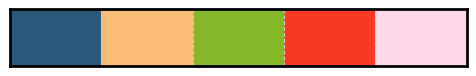

In [1]:
import seaborn as sns
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(r'..')
sys.path.append(r'.')
%load_ext autoreload
%autoreload 2

from process_data import process_mutation_data
from statistical_test import *

In [3]:
def violin_plot_for_mutation_distance(df, experiment_name, fig_name, split=True, inner='quart'):
    tmp_ax = sns.violinplot(x='benchmark_name', y='mutation', hue='algorithm', data=df, split=split, linewidth=1.5, inner=inner)
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

def box_plot_for_mutation_distance(df, experiment_name, fig_name):
    tmp_ax = sns.boxplot(data=df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [2]:
def beautify_stats_table(groupby):
    stats = groupby.describe()
    processed_stats = stats.loc[:, (slice(None), ['', 'count', '50%', 'mean', 'std', 'min', 'max'])].rename(columns={'50%':'median'})
    return processed_stats

In [4]:
def bar_plot_for_median_mutation_distance(stats_df, experiment_name, fig_name):
    # get the median values
    median_mutation_df = stats_df.loc[:, (slice(None), ['', 'median'])]
    # flatten the index
    median_mutation_df.columns = median_mutation_df.columns.get_level_values(0)
    # reorder the index 
    median_mutation_df = median_mutation_df.reindex([0, 5, 6, 1, 2, 3, 4, 7, 12, 13, 8, 9, 10, 11]).reset_index(drop=True)
    # bar plot
    tmp_ax = sns.barplot(median_mutation_df, x='benchmark_name', y='mutation', hue='algorithm')
    sns.move_legend(tmp_ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    plt.savefig('./figs/{}_{}.png'.format(experiment_name, fig_name), dpi=300)

In [5]:
def mann_whitney_u_test_for_mutation_distance(df, groupby, alg1_name, alg2_name):
    # TODO: remove either df or groupby
    # statistical tests
    result_dict = {}
    test_names = ['two-sided', 'less']
    measures = ['p', 'A_12', 'U1', 'U2', 'r1', 'r2']
    indices = []
    for name in test_names:
        indices += ['{}_{}'.format(name, measure) for measure in measures]

    # TODO: large, unequal sample sizes; debugging required
    for benchmark_name in df.benchmark_name.unique():
        print('testing {}...'.format(benchmark_name))
        alg1_data = groupby.get_group((alg1_name, benchmark_name)).mutation.values
        alg2_data = groupby.get_group((alg2_name, benchmark_name)).mutation.values
        print('sample1 size: {}, sample2 size: {}'.format(len(alg1_data), len(alg2_data)))
        result_two_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[0], verbose=False)
        result_one_sided = mann_whitney_u_test(alg1_data, alg2_data, alternative=test_names[1], verbose=False)
        result_dict[benchmark_name] = list(result_two_sided) + list(result_one_sided)
    # create the dataframe
    stats_df = pd.DataFrame(result_dict, index=indices) 
    return stats_df

# RQ1: How destructive are Zest's mutations in general? Are disruptive mutations beneficial for fuzzing?

In [4]:
experiment_name = 'ei-m510-mutation'
#process_mutation_data('/data/aoli/results-JQF/{}/'.format(experiment_name), [False, True], ["testWithGenerator"], ["zest", "ei"])
# load the df from pickle
mutation_df = pd.read_pickle('./mutation.pkl')

In [4]:
mutation_df['algorithm'].unique()

array(['zest-testWithGenerator', 'zest-testWithGenerator-saved_only',
       'ei-testWithGenerator', 'ei-testWithGenerator-saved_only'],
      dtype=object)

In [5]:
zest_df = mutation_df[mutation_df['algorithm'].str.contains('zest')]
ei_df = mutation_df[~mutation_df.index.isin(zest_df.index)]
saved_only_df = mutation_df[mutation_df['algorithm'].str.contains('saved_only')]
all_input_df = mutation_df[~mutation_df.index.isin(saved_only_df.index)]

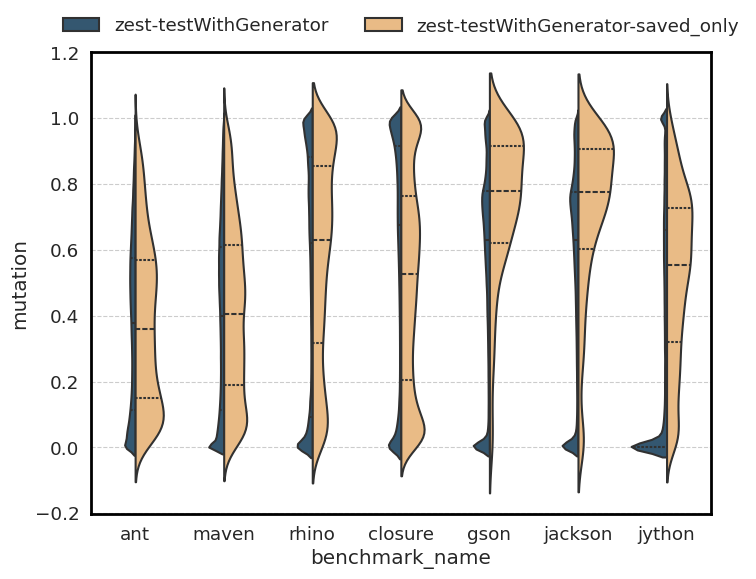

In [9]:
# violin split plot 
violin_plot_for_mutation_distance(zest_df, experiment_name, 'zest_violin_plot', split=True, inner='quart')

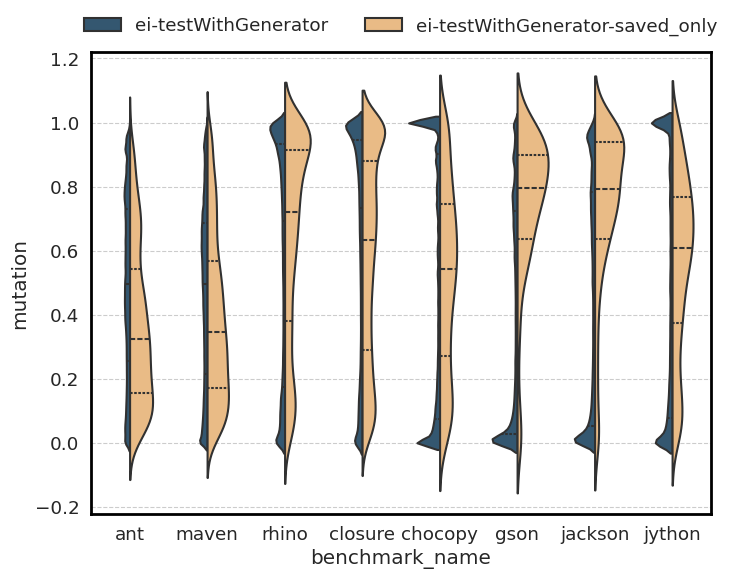

In [10]:
violin_plot_for_mutation_distance(ei_df, experiment_name, 'ei_violin_plot', split=True, inner='quart')

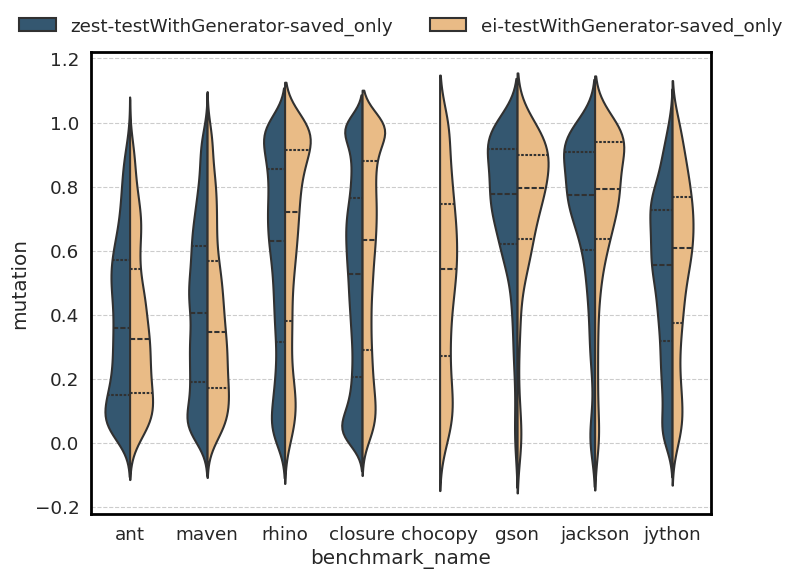

In [12]:
violin_plot_for_mutation_distance(saved_only_df, experiment_name, 'saved_input_violin_plot', split=True, inner='quart')

KeyboardInterrupt: 

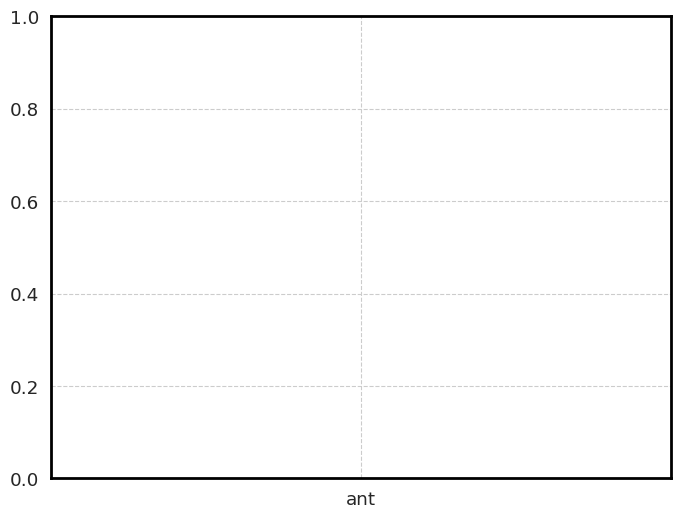

In [14]:
violin_plot_for_mutation_distance(all_input_df, experiment_name, 'all_input_violin_plot', split=True, inner='quart')

In [20]:
# stats table 
mutation_groupby = mutation_df.groupby(['algorithm', 'benchmark_name'], as_index=False)
all_input_stats = beautify_stats_table(mutation_groupby)
bar_plot_for_median_mutation_distance(all_input_stats, experiment_name, 'bar_plot_median_mutation_distance')

AttributeError: 'NoneType' object has no attribute 'loc'

In [21]:
all_input_stats

In [ ]:
#box_plot_for_mutation_distance(zest_df, experiment_name, 'zest_box_plot')